# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [166]:
import os
import pandas as pd
import zipfile 
import geopandas as gp
import numpy as np
import urllib
import matplotlib.pyplot as plt
import pylab as pl
import scipy.cluster as scp

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. Get Data
### Download Zipcode Shapefile

In [167]:
# download
url = " https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
urllib.request.urlretrieve(url,'fname.zip')

('fname.zip', <http.client.HTTPMessage at 0x7fe644324400>)

In [168]:
# movefile
!mv fname.zip $PUIDATA

In [169]:
# unzip
zip_ref = zipfile.ZipFile( os.getenv("PUIDATA") + "/" +"fname.zip", 'r')
zip_ref.extractall( os.getenv("PUIDATA") )
zip_ref.close()

In [170]:
# Read Data
shp = gp.GeoDataFrame.from_file(os.getenv('PUIDATA')+'/'+'ZIP_CODE_040114.shp')
print(shp.shape)
shp.head()

(263, 13)


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [171]:
shp = shp.drop_duplicates("ZIPCODE")
print(shp.shape)

(248, 13)


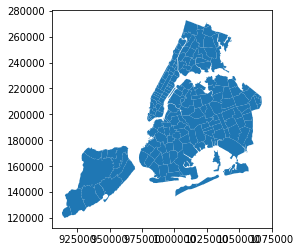

In [172]:
shp.plot()

In [173]:
zipcode = shp['ZIPCODE'].to_frame().astype('int')
print(zipcode.shape)
# print(zipcode)

(248, 1)


### Download census bureau business data

In [174]:
zipIndex = ['00','01','02', '03', '04', '05','06', '07', '08', '09', '10', '11',
            '12', '13', '14', '94', '95', '96', '97', '98', '99']
zipfnamelist = []
for i in zipIndex:
    url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp' + i + 'totals.zip'
    fname = os.getenv('PUIDATA')+'/' + 'zbp' + i + 'totals.zip'
    zipfnamelist.append(fname)
    urllib.request.urlretrieve(url, fname)

In [175]:
# print(zipcode.head())
for idx in zipIndex:
    fname =os.getenv('PUIDATA')+'/' 'zbp' + idx + 'totals.zip'
    zf = zipfile.ZipFile(fname, 'r')
    zf.extractall( os.getenv("PUIDATA") )
    df = pd.read_csv(fname.replace('.zip','.txt'))
    df.columns = map(str.upper, df.columns)
    temp = pd.DataFrame()
    temp[idx] = df['EST']
    temp['ZIP'] = df['ZIP']
    zipcode = pd.merge(zipcode, temp, left_on='ZIPCODE', right_on='ZIP', how='left').drop(['ZIP'],axis=1)
zipcode.head()
wzipcode = zipcode

# 2. Data clean 

#### "standardization" of the time seris
#### the patterns in the time series are what you are clustering on (time series goes up and down, creating a pattern) 
#### and those patterns would be lost by whitening.
#### So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.
#### From each row of your table (observation, in this case each zipcode)
#### subtract the mean and you divide the row by the standard deviation.

In [176]:
import geopandas as gp
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [177]:
cbs = zipcode.copy()
cbs.index = cbs.ZIPCODE
cbs = cbs.drop(['ZIPCODE'],axis=1)
cbs.head()

,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,65.0,57.0,78.0,74.0,84.0,82.0,80.0,84.0,90.0,92.0,...,101.0,95.0,99.0,109.0,51.0,50.0,53.0,51.0,51.0,58.0
11213,477.0,493.0,546.0,569.0,570.0,556.0,565.0,556.0,592.0,621.0,...,674.0,726.0,755.0,772.0,406.0,420.0,433.0,456.0,476.0,473.0
11212,520.0,527.0,577.0,581.0,586.0,587.0,570.0,587.0,602.0,647.0,...,713.0,721.0,731.0,752.0,505.0,494.0,502.0,527.0,519.0,541.0
11225,417.0,422.0,479.0,488.0,492.0,491.0,499.0,514.0,520.0,543.0,...,597.0,623.0,673.0,696.0,381.0,387.0,388.0,410.0,416.0,409.0
11218,1161.0,1180.0,1228.0,1247.0,1295.0,1332.0,1331.0,1377.0,1397.0,1457.0,...,1523.0,1605.0,1687.0,1736.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0


In [178]:
# 20 years of data and 263 zipcodes
cbs.shape

(248, 21)

In [179]:
#cleaning all missing values
cleancsb = cbs.dropna(axis=0, how='all').fillna(value=0)

In [180]:
#cleaning all missing values
cleancsb.shape

(245, 21)

In [181]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [182]:
test = zipcode


# 3. Cluster the NUMBER OF ESTABLISHMENTS time series with K-means

In [183]:
# zipcode.dropna(how='all',axis=0,inplace=True)
# print(zipcode)
# print(zipcode.iloc[:,1:])
zipcode = test
# print(zipcode)
mean = zipcode.iloc[:,1:].mean(axis=1)
std = zipcode.iloc[:,1:].std(axis=1)
zipcode.iloc[:,1:] = zipcode.iloc[:,1:].apply(lambda x: (x- mean) / std)
# zipcode.fillna(0, inplace = True)
zipcode = zipcode.iloc[:, 1:]
zipcode.head()
zipcode.shape

(248, 21)

In [184]:
#cluster with kmeans
nc= 5
for i in range(5):
    km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [185]:
zipcode.fillna(0, inplace = True)
zipcode.head()
silhouette_avg = {}
for i in range(2,10):
    KM = KMeans(n_clusters=i, random_state=666)
    res = KM.fit(zipcode.iloc[:, :21])
    zipcode['label' + str(i)] = res.labels_
    silhouette_avg[i]  = silhouette_score(zipcode, res.labels_)
print(silhouette_avg)
zipcode.head()


{2: 0.53287641029209576, 3: 0.49756273640898785, 4: 0.49330693530270175, 5: 0.35927544341944151, 6: 0.36493907358855598, 7: 0.49748928013616911, 8: 0.43697992610375569, 9: 0.33208977718205979}


,00,01,02,03,04,05,06,07,08,09,...,98,99,label2,label3,label4,label5,label6,label7,label8,label9
0,-0.578478,-0.988538,0.087870,-0.117160,0.395415,0.292900,0.190385,0.395415,0.702960,0.805475,...,-1.296083,-0.937280,1,0,2,2,1,5,1,2
1,-0.783015,-0.636364,-0.150580,0.060232,0.069398,-0.058923,0.023569,-0.058923,0.271044,0.536850,...,-0.792181,-0.819678,1,0,2,2,1,5,1,4
2,-0.897644,-0.813490,-0.212389,-0.164301,-0.104191,-0.092169,-0.296543,-0.092169,0.088161,0.629152,...,-0.909666,-0.645182,1,0,2,2,1,5,7,4
3,-0.841764,-0.788775,-0.184704,-0.089324,-0.046933,-0.057531,0.027251,0.186217,0.249804,0.493552,...,-0.852361,-0.926545,1,0,2,2,1,5,7,4
4,-0.665648,-0.578281,-0.357567,-0.270200,-0.049486,0.120649,0.116050,0.327569,0.419533,0.695427,...,-0.863371,-0.720826,1,0,2,2,1,5,1,4


# 4. plot the cluster centers

In [186]:
x = range(21)
def plotKMC(num):
    fig = pl.figure(figsize=(20,15))
    for i in range(num):
        ax = fig.add_subplot(num/2 + 1,2,i+1)
        sub = zipcode[zipcode['label' + str(num)]==i].iloc[:,range(21)]
        mean = sub.mean(axis=0)

        for j in range(len(sub)):
            ax.plot(x,sub.iloc[j,range(21)],'black' ,alpha=0.6)
        ax.plot(x,mean,'orange',linewidth=8)
        ax.set_title('Cluster {}'.format(i))
        ax.set_xlabel('Year')
    pl.show()
    

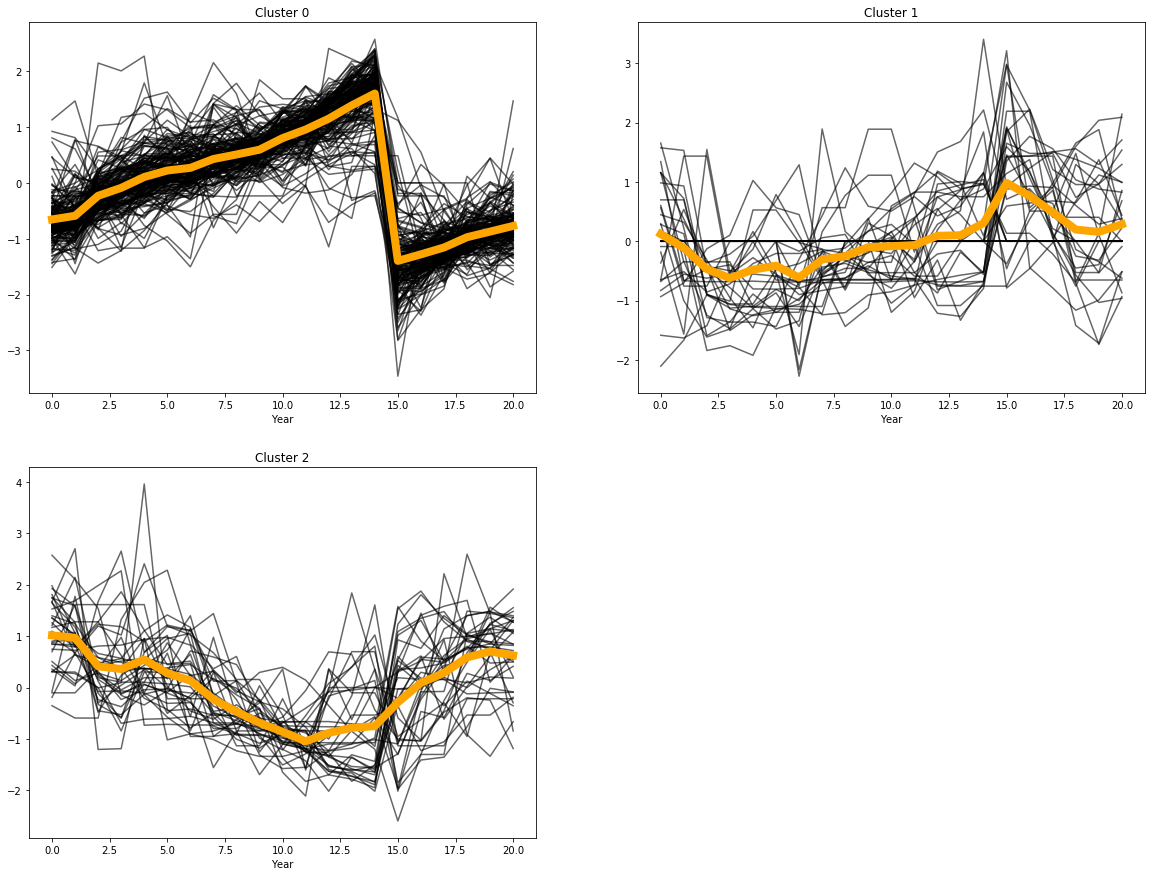

In [187]:
plotKMC(3)

### Figure 1: KMeans cluster with the cluster centers. Number of clusters is 3.

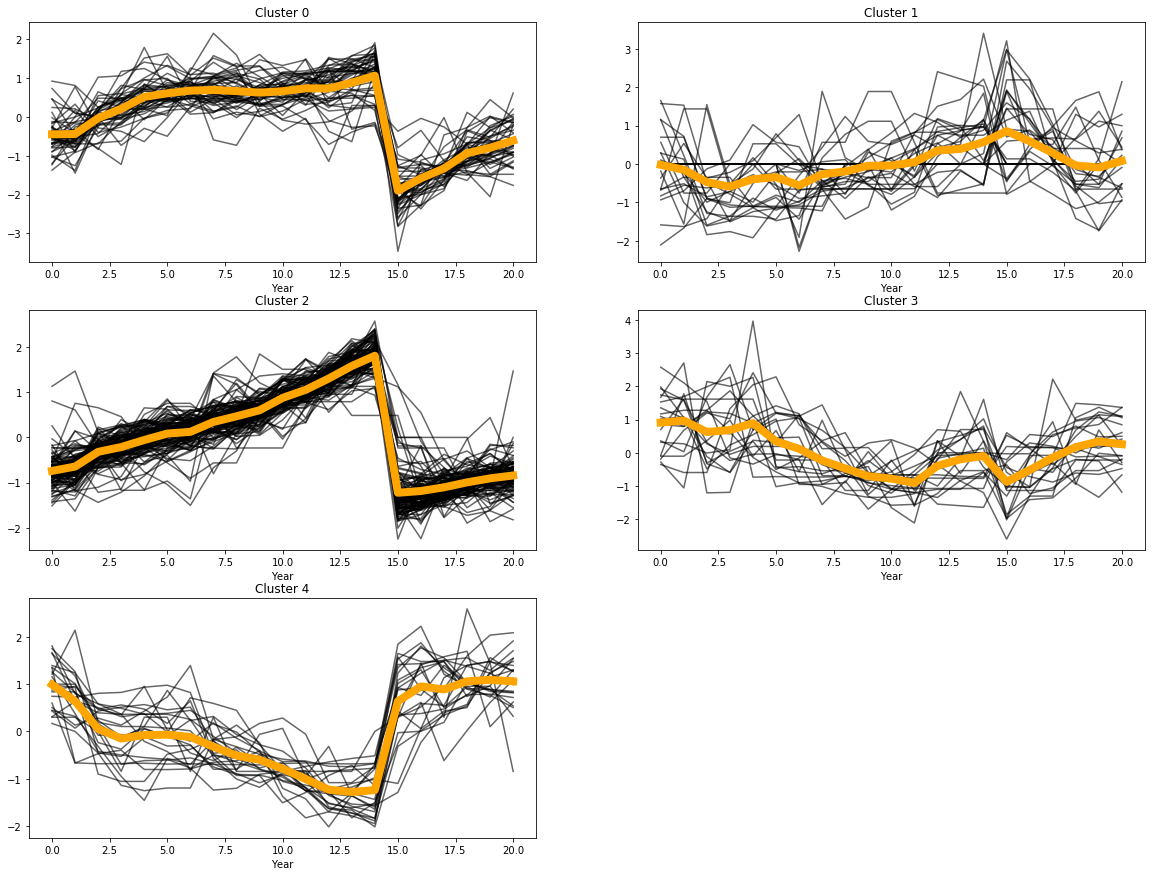

In [188]:
plotKMC(5)

### Figure 2: KMeans cluster with the cluster centers. Number of clusters is 5.

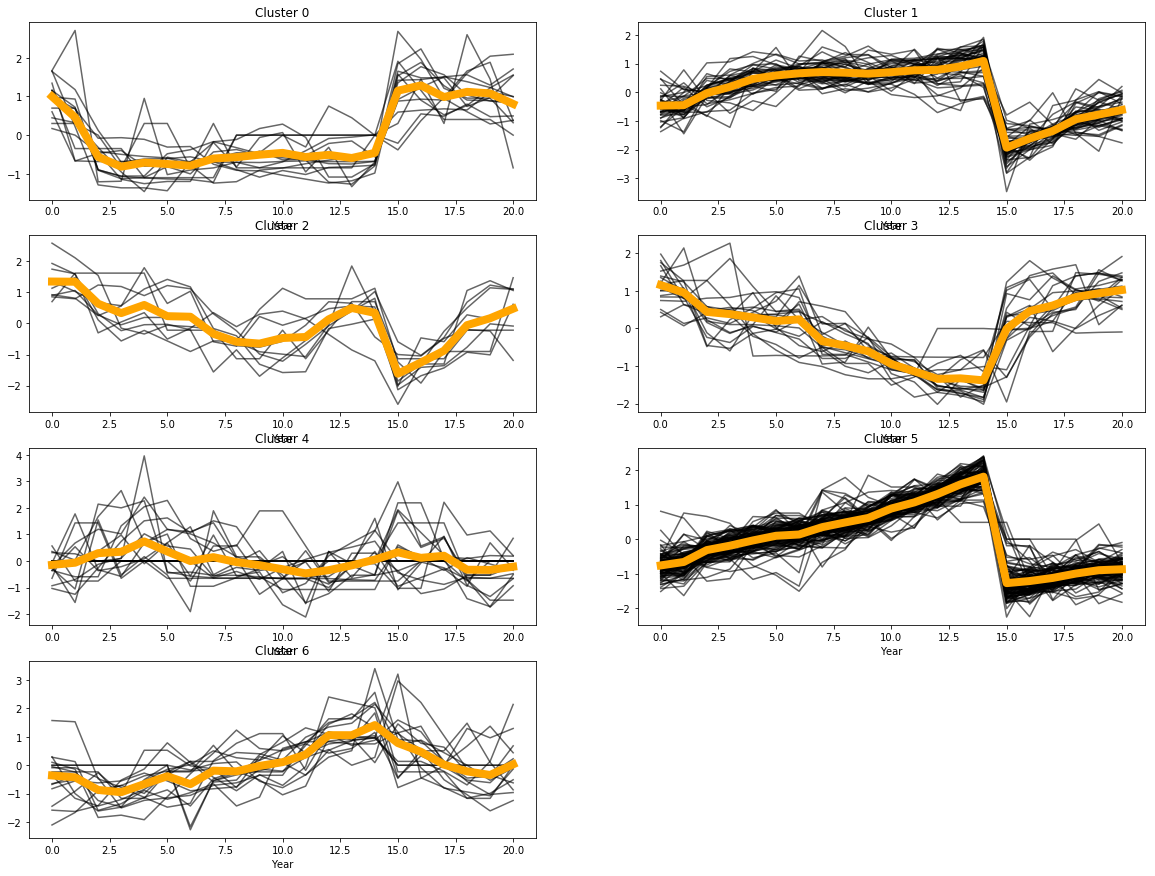

In [189]:
plotKMC(7)

### Figure 3:  KMeans cluster with the cluster centers. Number of clusters is 7.

# 5. Use another clustering algorithm (agglomerative clustering)

Text(0.5,1,'number of establishments dendrogram: \n the cluster hierarchical structure')

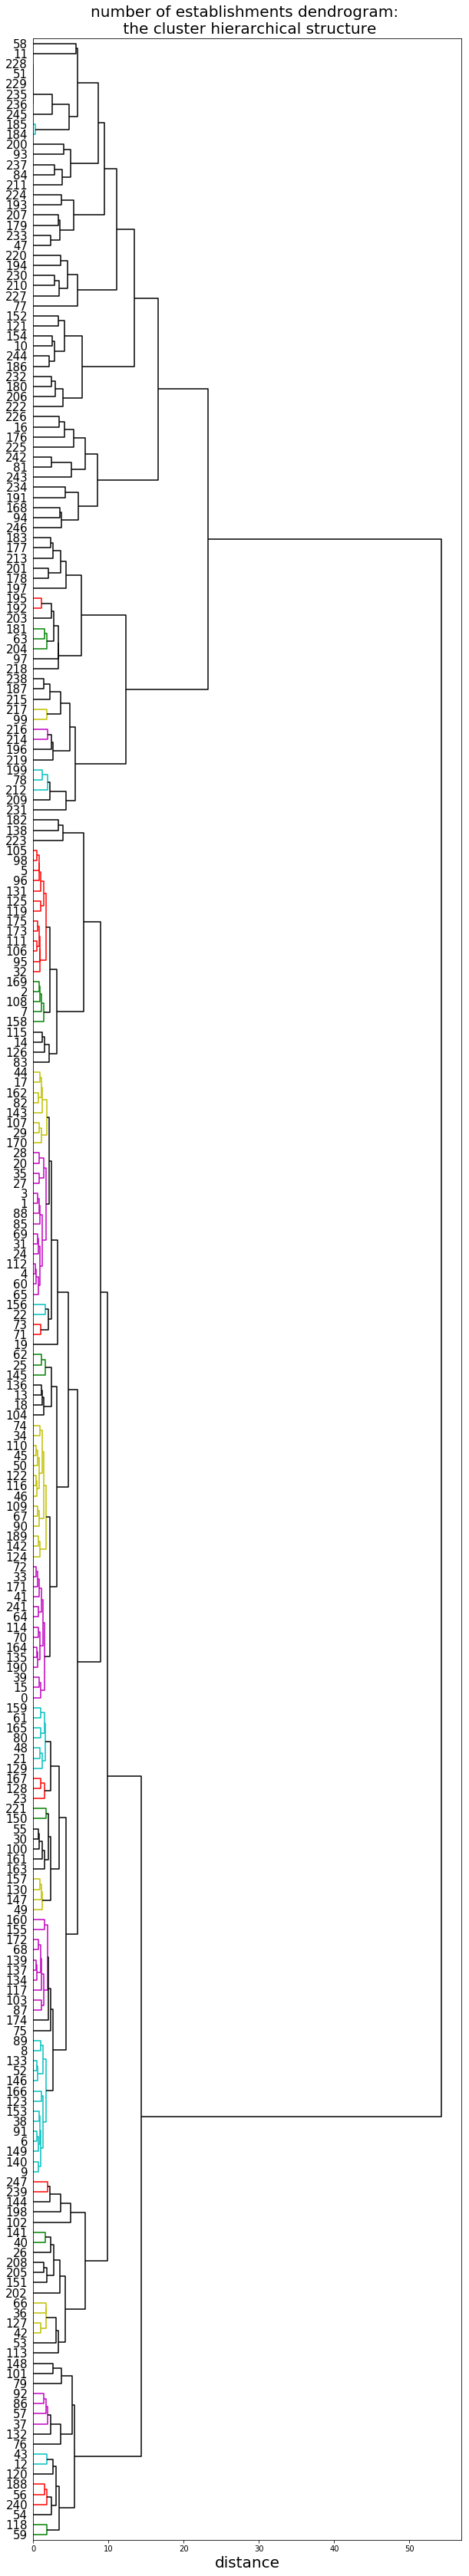

In [190]:
fig = pl.figure(figsize=(10,60))

ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage( zipcode.iloc[:,range(21)].as_matrix(), method='ward'),
                               labels = zipcode.index.values,
                               leaf_rotation=90.,# rotates the x axis labels
                               leaf_font_size=20, p=12, #truncate_mode='lastp', 
                               show_contracted=True, color_threshold = 2, 
                               orientation='right', above_threshold_color='k'
                              )  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.xlabel("distance", fontsize=20)
pl.yticks(fontsize=15, rotation=0)
pl.grid('off')
pl.title("number of establishments dendrogram: \n the cluster hierarchical structure", fontsize=20)

### Figure 4: Dandrogram of number of establishments clusters

In [191]:
for i in range(2, 8):
    agc = AgglomerativeClustering(n_clusters = i, compute_full_tree = True).fit(zipcode)
    zipcode['H_label' + str(i)] = agc.labels_

In [192]:
def plotHC(num):
    x = range(21)
    fig = pl.figure(figsize=(20,15))
    for i in range(num):
        ax = fig.add_subplot(num/2 + 1,2,i+1)
        sub = zipcode[zipcode['H_label' + str(num)]==i].iloc[:,range(21)]
        mean = sub.mean(axis=0)

        for j in range(len(sub)):
            ax.plot(x,sub.iloc[j,range(21)],'blue' ,alpha=0.6)
        ax.plot(x,mean,'black',linewidth=8)
        ax.set_title('Cluster {}'.format(i))
        ax.set_xlabel('Year')
    pl.show()

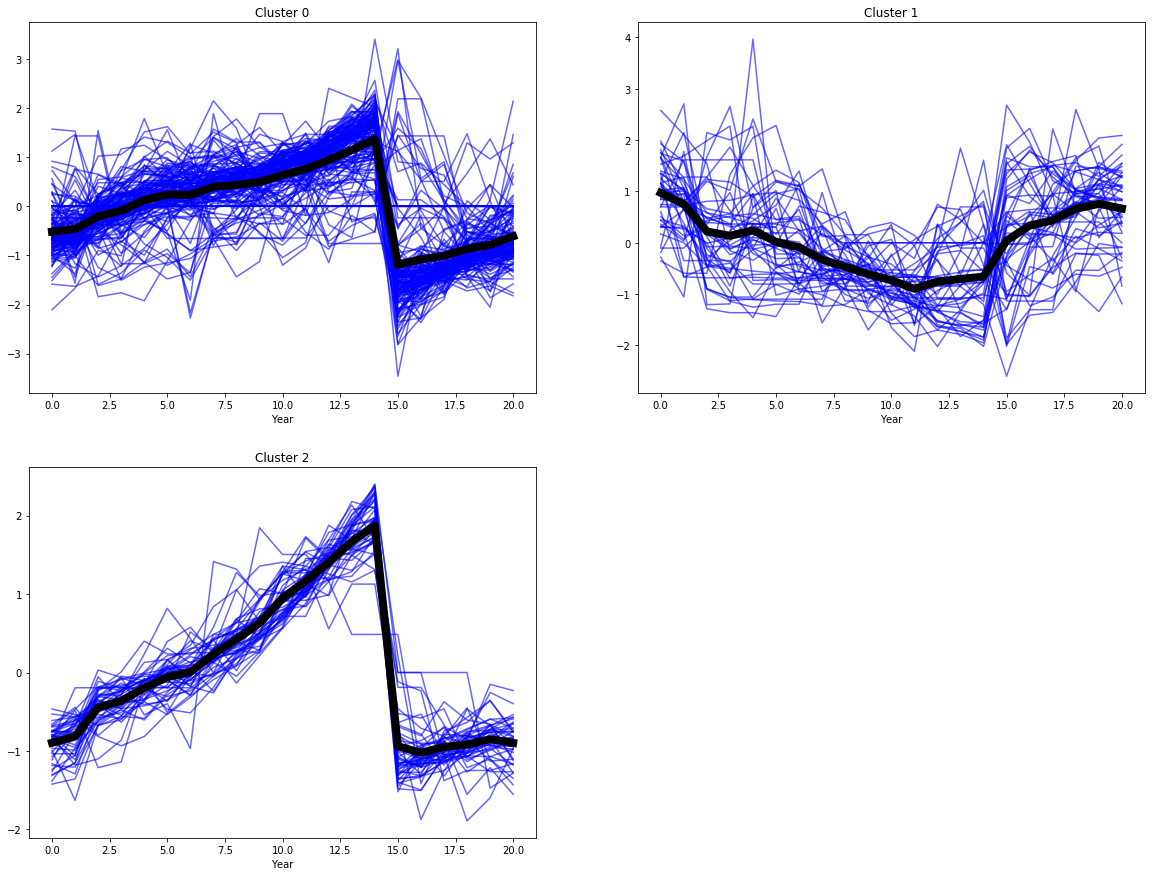

In [193]:
plotHC(3)

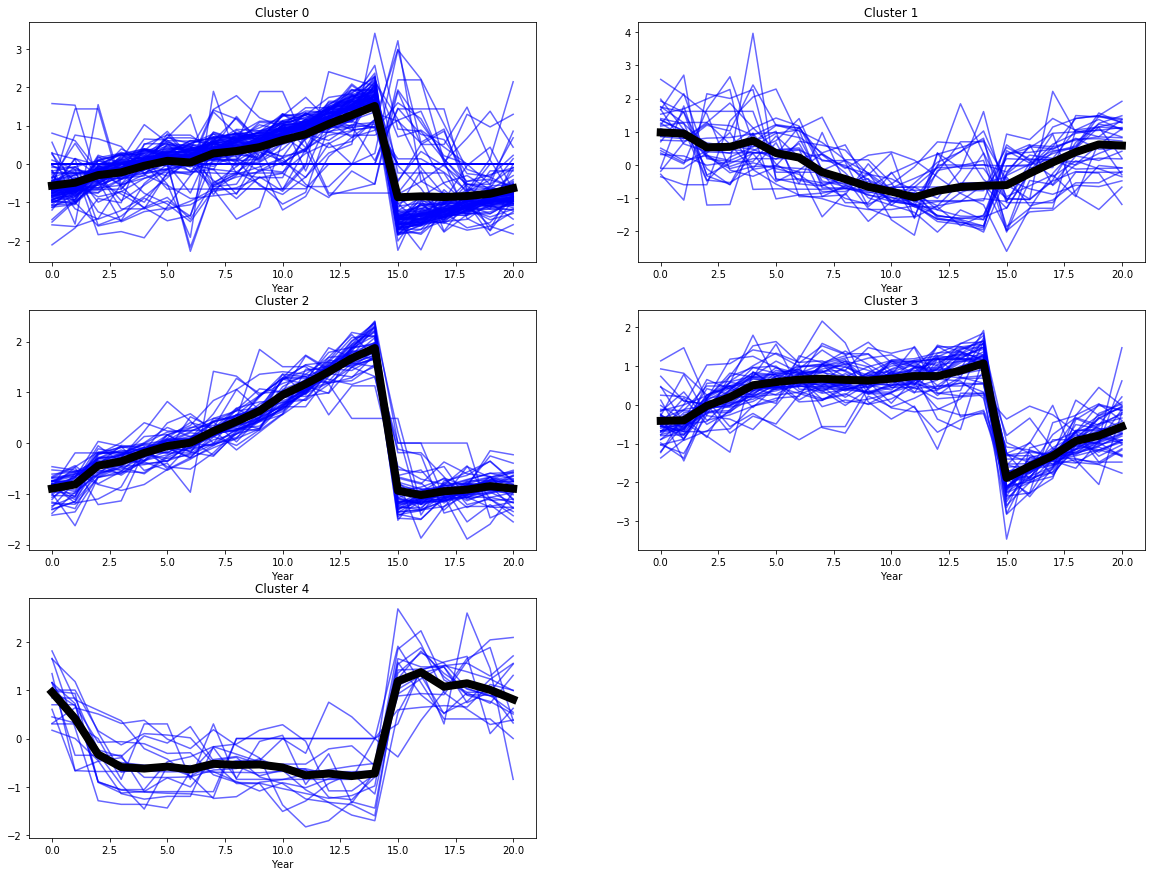

In [194]:
plotHC(5)

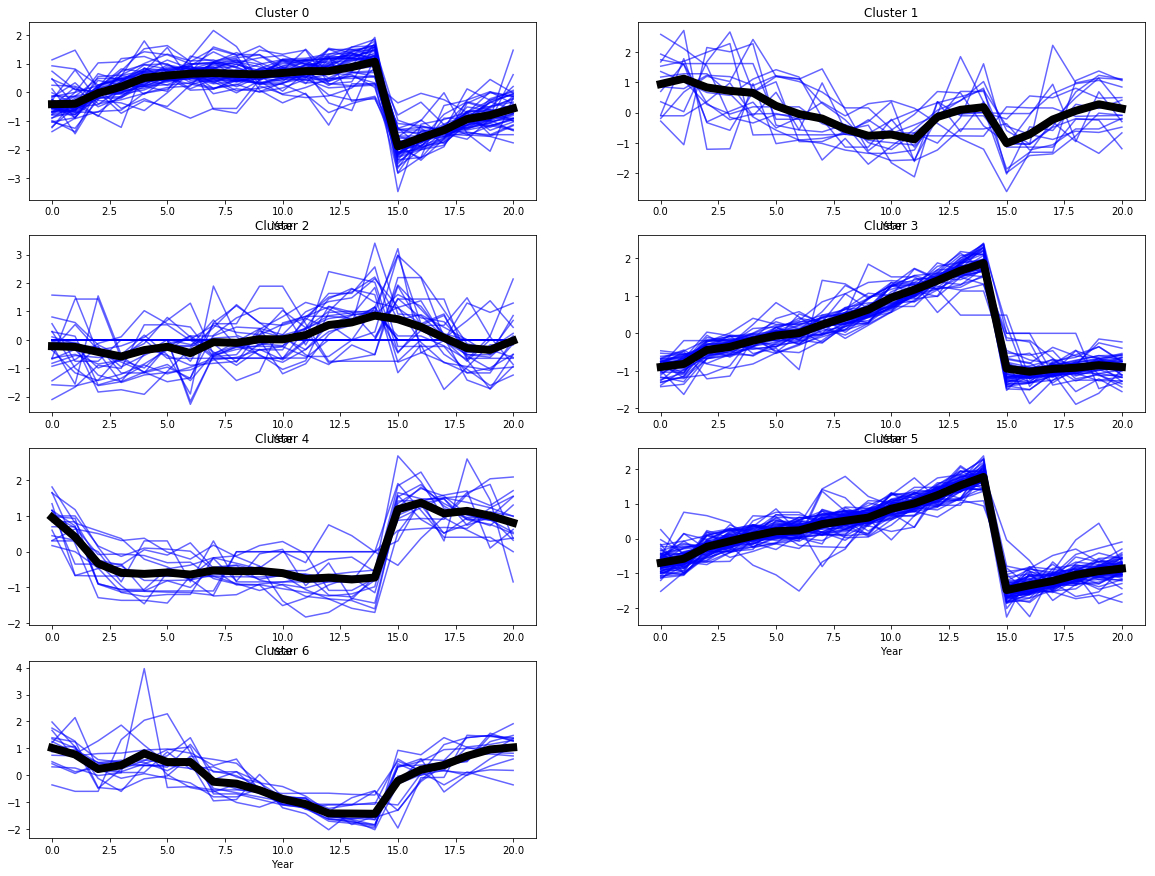

In [195]:
plotHC(7)

# 6. overlay your data on a NYC map

In [196]:
shp.ZIPCODE = shp.ZIPCODE.astype(int)
wzipcode['label5'] = zipcode['label5']
wzipcode['H_label5'] = zipcode['H_label5']
NYCzipcode = shp.merge(wzipcode,left_on='ZIPCODE', right_on = 'ZIPCODE')
NYCzipcode.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,13,14,94,95,96,97,98,99,label5,H_label5
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,1.164278,1.676853,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,2,0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,1.765058,1.920875,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,2,0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,1.639001,1.891464,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,2,2
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,1.871258,2.115007,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,2,2
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,1.753018,1.978331,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,2,0


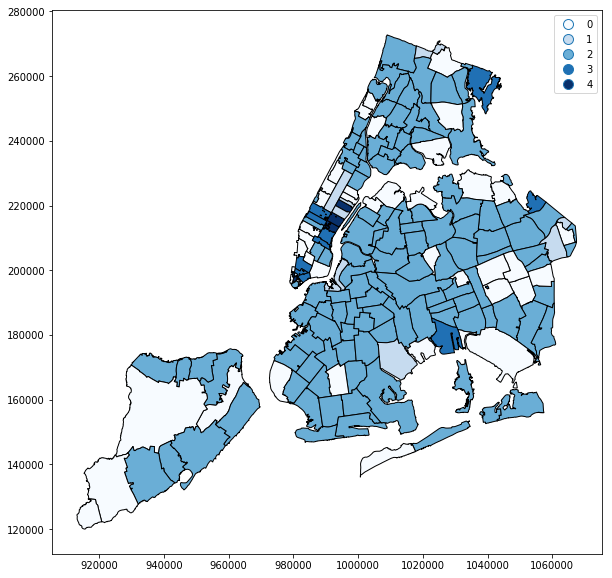

In [197]:
NYCzipcode.plot(figsize=(10,10),column='label5',cmap='Blues',edgecolor='black',legend=True,categorical=True)

### Figure 5  k-means clusters (n=5) at the zipcode level for NYC zipcodes

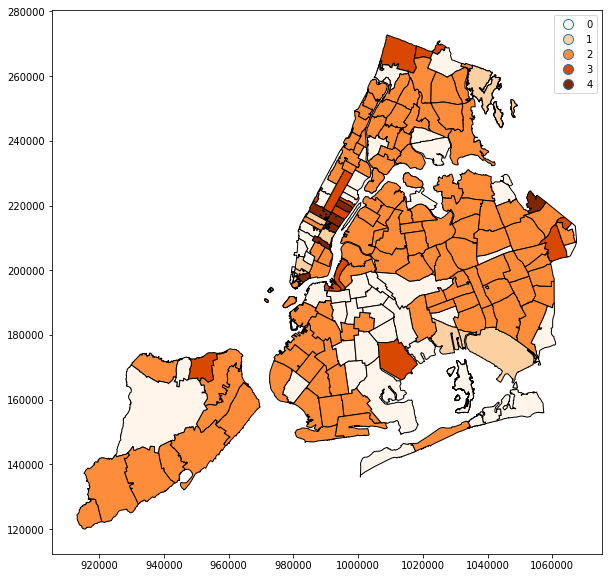

In [237]:
NYCzipcode.plot(figsize=(10,10),column='H_label5',cmap='Oranges',edgecolor='black',legend=True,categorical=True)

### Figure 6 agglomerative clusters (n=5) at the zipcode level for NYC zipcodes

# 7. Compare the results of the 2 algorithms and Interpretation

### Accroding to two maps above, we could find that in general they are the same, however, in some areas they displays slight differences. The area around downtown Brooklyn,  8th ave Brooklyn, north areas in Queens are different